![Cloud-First](../image/CloudFirst.png)


# SIT742: Modern Data Science
**(Module: Advanced Data Generation in Big Data Analytics)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.
- If you found any issue/bug for this document, please submit an issue at [tulip-lab/sit742](https://github.com/tulip-lab/sit742/issues)


Prepared by **SIT742 Teaching Team**

---


## Session 6G: Advanced Data Generation

In most recent development of data generation models, the large language models (LLMs) have shown significant advantages on data generations. In this notebook, we will leverage the most recent technologies in LLMs on image-text data generation and explore the image with its generated textual content together.   

## **Introduction of HuggingFace Image to Text**

Image to text models output a text from a given image. Image captioning or optical character recognition can be considered as the most common applications of image to text.

1.   Image Captioning is the process of generating textual description of an image. This can help the visually impaired people to understand what's happening in their surroundings.
2.   Optical Character Recognition (OCR), OCR models convert the text present in an image, e.g. a scanned document, to text.



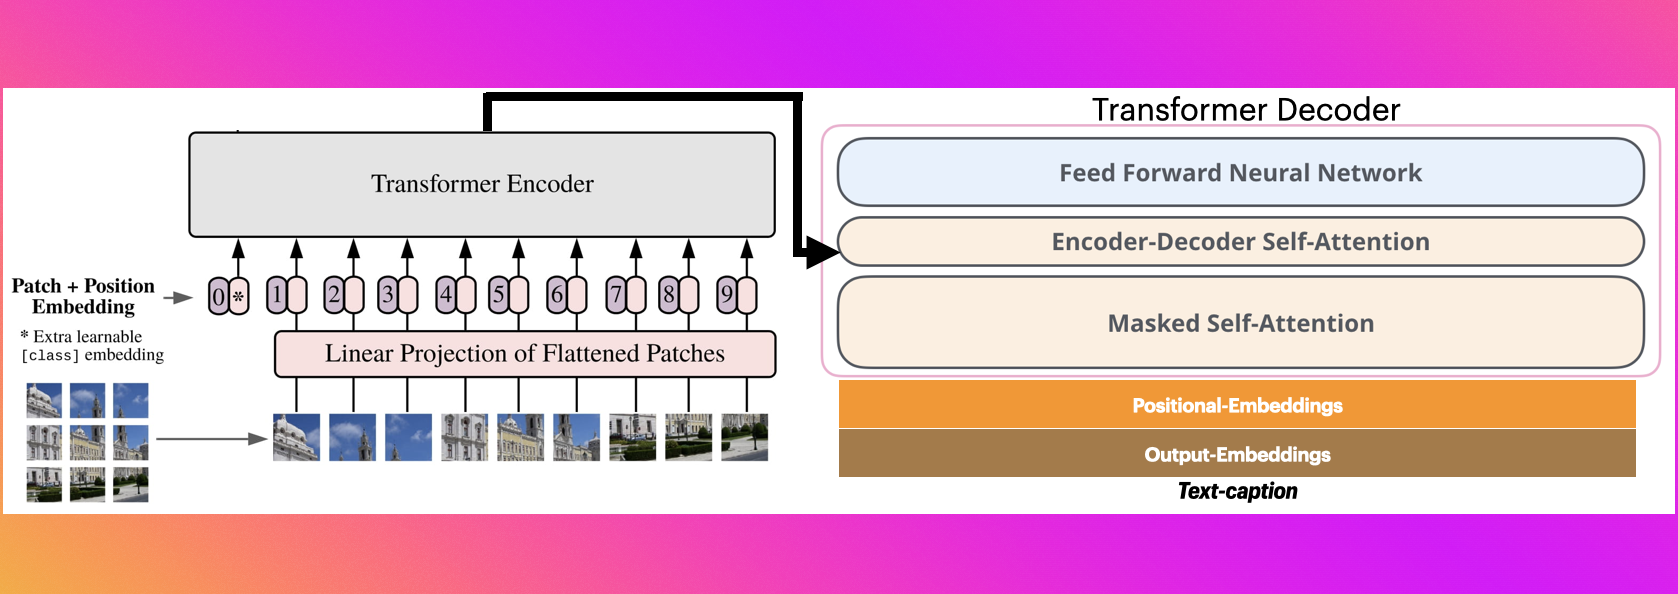

Above is one of the state of art LLM model for image - text generations.
The model based on the transformer structure with VisionEncoderDecoder (pre-trained) provide the capacity to generate the textual content data for describing the given image. VisionEncoderDecoderModel can be initialized from a pretrained encoder checkpoint and a pretrained decoder checkpoint. Note that any pretrained Transformer-based vision model, e.g. Swin, can serve as the encoder and both pretrained auto-encoding models, e.g. BERT, pretrained causal language models, e.g. GPT2, as well as the pretrained decoder part of sequence-to-sequence models, e.g. decoder of BART, can be used as the decoder. Depending on which architecture you choose as the decoder, the cross-attention layers might be randomly initialized.

*Some resource above is from "https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder" and "https://huggingface.co/nlpconnect/vit-gpt2-image-captioning"*

## **Start: Import Needed Libraries**

In [ ]:
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

## **Load Model**

In [ ]:
# Get Model
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# Get Image Feature Extractor
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
# Get Tokenizer Model
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Apply model on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# The maximum length the generated tokens can have
max_length = 64
#  Number of beams for beam search
num_beams = 1
# Generation Config
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

## **Prediction Function**

In [ ]:
def predict_step(image_paths):
    images = []
    for image_path in image_paths:
        img = Image.open(image_path)
        if img.mode != "RGB":
            img = img.convert(mode="RGB")

        images.append(img)

    # Feature Extractor
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # Apply model
    output_ids = model.generate(pixel_values, **gen_kwargs)

    # Get text tokens
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    return preds

## **Test Model**

In [ ]:
# prompt: read all the image under path '/content/'

import os

image_paths = []
for filename in os.listdir('/content/'):
    if filename.endswith(('.jpg', '.png', '.jpeg')): # Add other image extensions if needed
        image_paths.append(os.path.join('/content/', filename))

print(f"Found {len(image_paths)} images in /content/:")
image_paths

# Now you can use image_paths with your predict_step function
# predictions = predict_step(image_paths)
# print(predictions)

In [ ]:
image_text = []
for image in image_paths:
  #image = '/content/DJgAuWHWsAA6wwm.jpg'
  img = cv2.imread(image)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()
  image_text.append(predict_step([image]))

In [ ]:
image_text

## **Explore the Generated Text from Image**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()# Fit and transform the processed titles

# Flatten the list of lists into a single list of strings
flat_image_text = [item for sublist in image_text for item in sublist]

count_data = count_vectorizer.fit_transform(flat_image_text)
count_data

## **Leverage the Topic Modelling [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)**

In [ ]:
import numpy as np
terms = count_vectorizer.get_feature_names_out()

# Count the popularity of words
total_counts = np.zeros(len(terms))
for t in count_data:
    total_counts+=t.toarray()[0]

count_dict = (zip(terms, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:40] #Take the top 40 words

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

plt.figure(2, figsize=(11, 3))
plt.subplot(title='40 most common words')
plt.bar(words, counts)
plt.xticks(x_pos, words, rotation=90)
plt.xlabel('words')
plt.ylabel('counts')
plt.show()

## **Processing the Text Content**

In [ ]:
#Remove highly frequent (Greater than 20%) and infrequent words (less than 1%)
keepIndex = [];
for t in range(len(total_counts)):
    if total_counts[t] < 25 and total_counts[t] > 5:
        keepIndex.append(t)

print('Number of Terms Remained: ', len(keepIndex))

#Save the remain ing term and frequency data
ReducedTerm = [terms[t] for t in keepIndex]
ReducedCount = count_data[:,keepIndex]
ReducedCount

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Tweak the two parameters below
number_topics = 4

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023)
lda.fit(ReducedCount)
#Trained LDA model
lda.components_

In [ ]:
#Word Probablities in Topics
Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(Word_Topics_Pro)

## **Run the Word Cloud to Analysis**

In [ ]:
!pip install wordcloud
from matplotlib import pyplot
from wordcloud import WordCloud
import math
rows = math.ceil(len(Word_Topics_Pro)/3)
fig, ax = pyplot.subplots(rows, 3, figsize=(15,2.5*rows))
[axi.set_axis_off() for axi in ax.ravel()]
for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    # convert to dictionary type - keep top 10 words
    Word_Frequency = dict(count_dict[0:10])
    # generate word cloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)
    # visualize word cloud in figure
    subfig_Row = math.floor(topic_idx/3)
    subfig_Col = math.ceil(topic_idx%3)
    ax[subfig_Row,subfig_Col].imshow(wordcloud)
    ax[subfig_Row,subfig_Col].set_title("Topic {}".format(topic_idx+1))
plt.show()

In [ ]:
#Compute topic distribution for each document
TopicDis_Doc = lda.transform(ReducedCount)

In [ ]:
TopicDis_Doc

In [ ]:
import pandas as pd
df_document_topics = pd.DataFrame(TopicDis_Doc)
df_document_topics

## **Output The Topic for Each Image**

In [ ]:
# prompt: for each topic, show the images

import pandas as pd
import matplotlib.pyplot as plt
# Add a 'dominant_topic' column to the dataframe
df_document_topics['dominant_topic'] = df_document_topics.idxmax(axis=1)

# Create a dataframe to map dominant topic to original image paths
df_image_topics = pd.DataFrame({'image_path': image_paths, 'dominant_topic': df_document_topics['dominant_topic']})

# Group the images by their dominant topic
grouped_images = df_image_topics.groupby('dominant_topic')['image_path'].apply(list)

# Iterate through each topic and display the corresponding images
for topic, images in grouped_images.items():
    print(f"\nImages for Topic {topic + 1}:")
    plt.figure(figsize=(15, 5)) # Adjust figure size as needed
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

For above analysis, could you please think with below questions and discuss with your lab tutor?


1.   Do you think Text-Image will have the similar structure comparing with Image to text?
2.   How do you think the quality of textual content generated according to each image?

1.   For improving the quality of generation, do you think a more powerful computation resource is required always? Anyother ideas?
2.   What is the purposed of "fine-tune" here?

1.   Any ethical issues you think it might have with the process of image to text?






